<a href="https://colab.research.google.com/github/vadhri/distibuted-optimization/blob/main/ADMM/sharing_power_grid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CSV file 'input_parameters.csv' generated with 1024 rows.


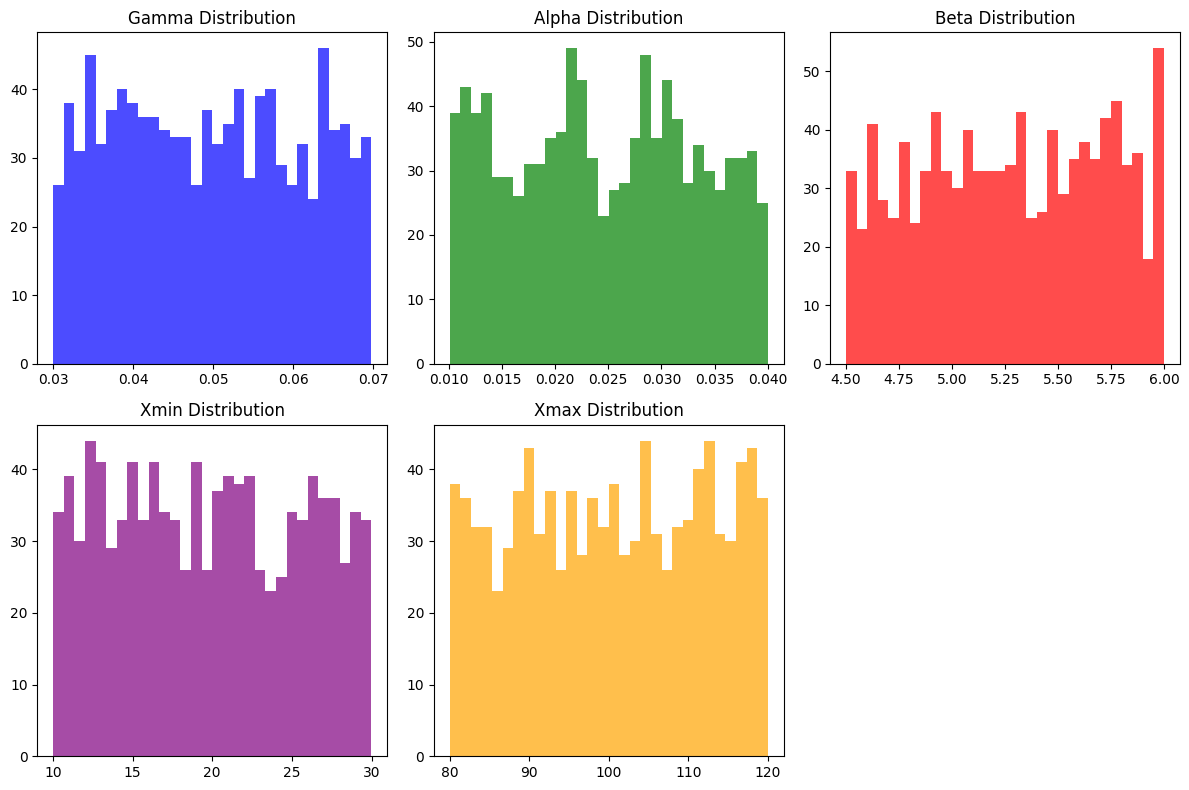

In [5]:
import csv
import random
import matplotlib.pyplot as plt

# Number of power stations (should match N in CUDA code)
N = 1024

# Lists to store synthetic parameters
gammas = []
alphas = []
betas = []
xmins = []
xmaxs = []

# CSV filename
filename = "input_parameters.csv"

# Generate synthetic data
for _ in range(N):
    gamma = round(random.uniform(0.03, 0.07), 4)
    alpha = round(random.uniform(0.01, 0.04), 4)
    beta  = round(random.uniform(4.5, 6.0), 2)
    xmin  = round(random.uniform(10.0, 30.0), 2)
    xmax  = round(random.uniform(80.0, 120.0), 2)

    gammas.append(gamma)
    alphas.append(alpha)
    betas.append(beta)
    xmins.append(xmin)
    xmaxs.append(xmax)

# Save to CSV
with open(filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['gamma', 'alpha', 'beta', 'xmin', 'xmax'])

    for i in range(N):
        writer.writerow([gammas[i], alphas[i], betas[i], xmins[i], xmaxs[i]])

print(f"CSV file '{filename}' generated with {N} rows.")

# Plot histograms
plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.hist(gammas, bins=30, color='blue', alpha=0.7)
plt.title('Gamma Distribution')

plt.subplot(2, 3, 2)
plt.hist(alphas, bins=30, color='green', alpha=0.7)
plt.title('Alpha Distribution')

plt.subplot(2, 3, 3)
plt.hist(betas, bins=30, color='red', alpha=0.7)
plt.title('Beta Distribution')

plt.subplot(2, 3, 4)
plt.hist(xmins, bins=30, color='purple', alpha=0.7)
plt.title('Xmin Distribution')

plt.subplot(2, 3, 5)
plt.hist(xmaxs, bins=30, color='orange', alpha=0.7)
plt.title('Xmax Distribution')

plt.tight_layout()
plt.show()


In [6]:
%%writefile cuda.cu
#include <stdio.h>
#include <stdlib.h>
#include <math.h>

#define N 1024
#define MAX_ITERS 5000
#define TOLERANCE 1e-4
#define BLOCK_SIZE 256

// CUDA kernels

__global__ void x_unconstrained_kernel(float *gamma, float *z, float *u, float *x_unproj, float rho, int n) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < n) {
        x_unproj[idx] = rho * (z[idx] - u[idx]) / (2.0f * gamma[idx] + rho);
    }
}

__global__ void x_project_kernel(float *x_unproj, float *x, float delta, float *x_min, float *x_max, int n) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < n) {
        float xi = x_unproj[idx] + delta;
        if (xi < x_min[idx]) xi = x_min[idx];
        if (xi > x_max[idx]) xi = x_max[idx];
        x[idx] = xi;
    }
}

__global__ void z_update_kernel(float *alpha, float *beta, float *x, float *u, float *z, float rho, int n) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < n) {
        float A = x[idx] + u[idx];
        z[idx] = (rho * A - beta[idx]) / (2.0f * alpha[idx] + rho);
    }
}

float gpu_sum(float *d_array, int n) {
    float *h_array = (float*)malloc(n * sizeof(float));
    cudaMemcpy(h_array, d_array, n * sizeof(float), cudaMemcpyDeviceToHost);

    float sum = 0.0f;
    for (int i = 0; i < n; i++) sum += h_array[i];
    free(h_array);
    return sum;
}

// CSV reader
void read_csv(const char* filename, float* gamma, float* alpha, float* beta, float* xmin, float* xmax, int n) {
    FILE* file = fopen(filename, "r");
    if (!file) {
        printf("Error opening CSV file.\n");
        exit(1);
    }

    char line[256];
    int count = 0;
    fgets(line, sizeof(line), file);  // Skip header

    while (fgets(line, sizeof(line), file) && count < n) {
        sscanf(line, "%f,%f,%f,%f,%f",
               &gamma[count],
               &alpha[count],
               &beta[count],
               &xmin[count],
               &xmax[count]);
        count++;
    }

    fclose(file);

    if (count < n) {
        printf("Warning: CSV has only %d rows.\n", count);
    }
}

int main() {
    float rho = 1.0f;
    float demand = N * 50.0f;

    // Device memory allocation
    float *d_gamma, *d_z, *d_u, *d_x, *d_alpha, *d_beta, *d_xmin, *d_xmax, *d_x_unproj;
    cudaMalloc(&d_gamma,   N * sizeof(float));
    cudaMalloc(&d_z,       N * sizeof(float));
    cudaMalloc(&d_u,       N * sizeof(float));
    cudaMalloc(&d_x,       N * sizeof(float));
    cudaMalloc(&d_alpha,   N * sizeof(float));
    cudaMalloc(&d_beta,    N * sizeof(float));
    cudaMalloc(&d_xmin,    N * sizeof(float));
    cudaMalloc(&d_xmax,    N * sizeof(float));
    cudaMalloc(&d_x_unproj,N * sizeof(float));

    // Host memory
    float *gamma = (float*)malloc(N * sizeof(float));
    float *alpha = (float*)malloc(N * sizeof(float));
    float *beta  = (float*)malloc(N * sizeof(float));
    float *xmin  = (float*)malloc(N * sizeof(float));
    float *xmax  = (float*)malloc(N * sizeof(float));
    float *u     = (float*)calloc(N, sizeof(float));
    float *z     = (float*)calloc(N, sizeof(float));
    float *x     = (float*)calloc(N, sizeof(float));

    // CSV data loading
    read_csv("input_parameters.csv", gamma, alpha, beta, xmin, xmax, N);

    // Initialize z to mid-range value
    for (int i = 0; i < N; i++) {
        z[i] = 0.5f * (xmin[i] + xmax[i]);
    }

    // Copy to GPU
    cudaMemcpy(d_gamma, gamma, N * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_alpha, alpha, N * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_beta,  beta,  N * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_xmin,  xmin,  N * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_xmax,  xmax,  N * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_u,     u,     N * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_z,     z,     N * sizeof(float), cudaMemcpyHostToDevice);

    int grid_size = (N + BLOCK_SIZE - 1) / BLOCK_SIZE;

    // ADMM Iterations
    for (int iter = 0; iter < MAX_ITERS; iter++) {
        // x-update
        x_unconstrained_kernel<<<grid_size, BLOCK_SIZE>>>(d_gamma, d_z, d_u, d_x_unproj, rho, N);
        cudaDeviceSynchronize();

        float sum_x = gpu_sum(d_x_unproj, N);
        float delta = (demand - sum_x) / N;

        x_project_kernel<<<grid_size, BLOCK_SIZE>>>(d_x_unproj, d_x, delta, d_xmin, d_xmax, N);
        cudaDeviceSynchronize();

        // z-update
        z_update_kernel<<<grid_size, BLOCK_SIZE>>>(d_alpha, d_beta, d_x, d_u, d_z, rho, N);
        cudaDeviceSynchronize();

        // Dual variable update (CPU)
        cudaMemcpy(x, d_x, N * sizeof(float), cudaMemcpyDeviceToHost);
        cudaMemcpy(z, d_z, N * sizeof(float), cudaMemcpyDeviceToHost);
        cudaMemcpy(u, d_u, N * sizeof(float), cudaMemcpyDeviceToHost);

        float primal_residual = 0.0f;
        for (int i = 0; i < N; i++) {
            float diff = x[i] - z[i];
            u[i] += diff;
            primal_residual += diff * diff;
        }
        cudaMemcpy(d_u, u, N * sizeof(float), cudaMemcpyHostToDevice);

        primal_residual = sqrtf(primal_residual);

        if (iter % 10 == 0)
            printf("Iter %d: Residual = %.6f\n", iter, primal_residual);

        if (primal_residual < TOLERANCE) {
            printf("Converged at iteration %d\n", iter);
            break;
        }
    }

    // Final result
    float total_power = 0.0f;
    cudaMemcpy(x, d_x, N * sizeof(float), cudaMemcpyDeviceToHost);
    for (int i = 0; i < N; i++) {
        total_power += x[i];
    }
    printf("Total Generated Power = %.2f\n", total_power);

    // Cleanup
    cudaFree(d_gamma); cudaFree(d_z); cudaFree(d_u); cudaFree(d_x);
    cudaFree(d_alpha); cudaFree(d_beta); cudaFree(d_xmin); cudaFree(d_xmax); cudaFree(d_x_unproj);
    free(gamma); free(alpha); free(beta); free(xmin); free(xmax); free(u); free(z); free(x);

    return 0;
}


Overwriting cuda.cu


In [14]:
%%writefile cuda.cu
#include <stdio.h>
#include <stdlib.h>
#include <math.h>

#define N 1024
#define MAX_ITERS 5000
#define TOLERANCE 1e-4
#define BLOCK_SIZE 256

// CUDA kernels

__global__ void x_unconstrained_kernel(float *gamma, float *z, float *u, float *x_unproj, float rho, int n) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < n) {
        x_unproj[idx] = rho * (z[idx] - u[idx]) / (2.0f * gamma[idx] + rho);
    }
}

__global__ void x_project_kernel(float *x_unproj, float *x, float delta, float *x_min, float *x_max, int n) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < n) {
        float xi = x_unproj[idx] + delta;
        if (xi < x_min[idx]) xi = x_min[idx];
        if (xi > x_max[idx]) xi = x_max[idx];
        x[idx] = xi;
    }
}

__global__ void z_update_kernel(float *alpha, float *beta, float *x, float *u, float *z, float rho, int n) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < n) {
        float A = x[idx] + u[idx];
        z[idx] = (rho * A - beta[idx]) / (2.0f * alpha[idx] + rho);
    }
}

float gpu_sum(float *d_array, int n) {
    float *h_array = (float*)malloc(n * sizeof(float));
    cudaMemcpy(h_array, d_array, n * sizeof(float), cudaMemcpyDeviceToHost);

    float sum = 0.0f;
    for (int i = 0; i < n; i++) sum += h_array[i];
    free(h_array);
    return sum;
}

void read_csv(const char* filename, float* gamma, float* alpha, float* beta, float* xmin, float* xmax, int n) {
    FILE* file = fopen(filename, "r");
    if (!file) {
        printf("Error opening CSV file.\n");
        exit(1);
    }

    char line[256];
    int count = 0;
    fgets(line, sizeof(line), file);  // Skip header

    while (fgets(line, sizeof(line), file) && count < n) {
        sscanf(line, "%f,%f,%f,%f,%f",
               &gamma[count],
               &alpha[count],
               &beta[count],
               &xmin[count],
               &xmax[count]);
        count++;
    }

    fclose(file);

    if (count < n) {
        printf("Warning: CSV has only %d rows.\n", count);
    }
}

int main() {
    float rho = 1.0f;
    float demand = N * 50.0f;

    float *d_gamma, *d_z, *d_u, *d_x, *d_alpha, *d_beta, *d_xmin, *d_xmax, *d_x_unproj;
    cudaMalloc(&d_gamma,   N * sizeof(float));
    cudaMalloc(&d_z,       N * sizeof(float));
    cudaMalloc(&d_u,       N * sizeof(float));
    cudaMalloc(&d_x,       N * sizeof(float));
    cudaMalloc(&d_alpha,   N * sizeof(float));
    cudaMalloc(&d_beta,    N * sizeof(float));
    cudaMalloc(&d_xmin,    N * sizeof(float));
    cudaMalloc(&d_xmax,    N * sizeof(float));
    cudaMalloc(&d_x_unproj,N * sizeof(float));

    float *gamma = (float*)malloc(N * sizeof(float));
    float *alpha = (float*)malloc(N * sizeof(float));
    float *beta  = (float*)malloc(N * sizeof(float));
    float *xmin  = (float*)malloc(N * sizeof(float));
    float *xmax  = (float*)malloc(N * sizeof(float));
    float *u     = (float*)calloc(N, sizeof(float));
    float *z     = (float*)calloc(N, sizeof(float));
    float *x     = (float*)calloc(N, sizeof(float));

    read_csv("input_parameters.csv", gamma, alpha, beta, xmin, xmax, N);

    for (int i = 0; i < N; i++) {
        z[i] = 0.5f * (xmin[i] + xmax[i]);
    }

    cudaMemcpy(d_gamma, gamma, N * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_alpha, alpha, N * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_beta,  beta,  N * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_xmin,  xmin,  N * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_xmax,  xmax,  N * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_u,     u,     N * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_z,     z,     N * sizeof(float), cudaMemcpyHostToDevice);

    int grid_size = (N + BLOCK_SIZE - 1) / BLOCK_SIZE;

    FILE* logfile = fopen("convergence_log.csv", "w");
    fprintf(logfile, "iteration,residual,f_x,g_z\n");

    for (int iter = 0; iter < MAX_ITERS; iter++) {
        x_unconstrained_kernel<<<grid_size, BLOCK_SIZE>>>(d_gamma, d_z, d_u, d_x_unproj, rho, N);
        cudaDeviceSynchronize();

        float sum_x = gpu_sum(d_x_unproj, N);
        float delta = (demand - sum_x) / N;

        x_project_kernel<<<grid_size, BLOCK_SIZE>>>(d_x_unproj, d_x, delta, d_xmin, d_xmax, N);
        cudaDeviceSynchronize();

        z_update_kernel<<<grid_size, BLOCK_SIZE>>>(d_alpha, d_beta, d_x, d_u, d_z, rho, N);
        cudaDeviceSynchronize();

        cudaMemcpy(x, d_x, N * sizeof(float), cudaMemcpyDeviceToHost);
        cudaMemcpy(z, d_z, N * sizeof(float), cudaMemcpyDeviceToHost);
        cudaMemcpy(u, d_u, N * sizeof(float), cudaMemcpyDeviceToHost);

        float primal_residual = 0.0f;
        for (int i = 0; i < N; i++) {
            float diff = x[i] - z[i];
            u[i] += diff;
            primal_residual += diff * diff;
        }
        cudaMemcpy(d_u, u, N * sizeof(float), cudaMemcpyHostToDevice);

        primal_residual = sqrtf(primal_residual);

        float f_x = 0.0f;
        float g_z = 0.0f;
        for (int i = 0; i < N; i++) {
            f_x += gamma[i] * x[i] * x[i];
            g_z += alpha[i] * z[i] * z[i] + beta[i] * z[i];
        }

        fprintf(logfile, "%d,%f,%f,%f\n", iter, primal_residual, f_x, g_z);

        if (iter % 10 == 0)
            printf("Iter %d: Residual = %.6f, f(x) = %.2f, g(z) = %.2f\n", iter, primal_residual, f_x, g_z);

        if (primal_residual < TOLERANCE) {
            printf("Converged at iteration %d\n", iter);
            break;
        }
    }

    fclose(logfile);

    float total_power = 0.0f;
    cudaMemcpy(x, d_x, N * sizeof(float), cudaMemcpyDeviceToHost);
    for (int i = 0; i < N; i++) {
        total_power += x[i];
    }
    printf("Total Generated Power = %.2f\n", total_power);

    FILE* xfile = fopen("final_x.csv", "w");
    fprintf(xfile, "generator,output_power\n");
    for (int i = 0; i < N; i++) {
        fprintf(xfile, "%d,%f\n", i, x[i]);
    }
    fclose(xfile);

    cudaFree(d_gamma); cudaFree(d_z); cudaFree(d_u); cudaFree(d_x);
    cudaFree(d_alpha); cudaFree(d_beta); cudaFree(d_xmin); cudaFree(d_xmax); cudaFree(d_x_unproj);
    free(gamma); free(alpha); free(beta); free(xmin); free(xmax); free(u); free(z); free(x);

    printf("Saved convergence log and final power outputs.\n");
    return 0;
}



Overwriting cuda.cu


In [15]:
!nvcc -gencode arch=compute_75,code=sm_75 cuda.cu -o cuda
!time ./cuda

Iter 0: Residual = 237.050781, f(x) = 127701.32, g(z) = 276122.19
Iter 10: Residual = 0.549810, f(x) = 124098.77, g(z) = 329483.59
Iter 20: Residual = 0.149242, f(x) = 123914.82, g(z) = 328872.72
Iter 30: Residual = 0.045411, f(x) = 123932.63, g(z) = 328715.81
Iter 40: Residual = 0.015128, f(x) = 123947.03, g(z) = 328667.44
Iter 50: Residual = 0.005391, f(x) = 123953.09, g(z) = 328651.31
Iter 60: Residual = 0.002005, f(x) = 123955.57, g(z) = 328645.22
Iter 70: Residual = 0.000776, f(x) = 123956.59, g(z) = 328643.53
Iter 80: Residual = 0.000316, f(x) = 123956.89, g(z) = 328642.50
Iter 90: Residual = 0.000146, f(x) = 123956.91, g(z) = 328642.25
Converged at iteration 98
Total Generated Power = 51200.05
Saved convergence log and final power outputs.

real	0m0.246s
user	0m0.026s
sys	0m0.213s


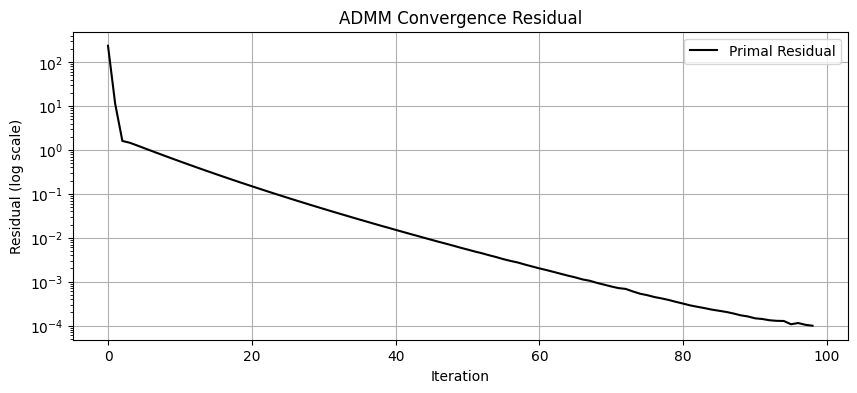

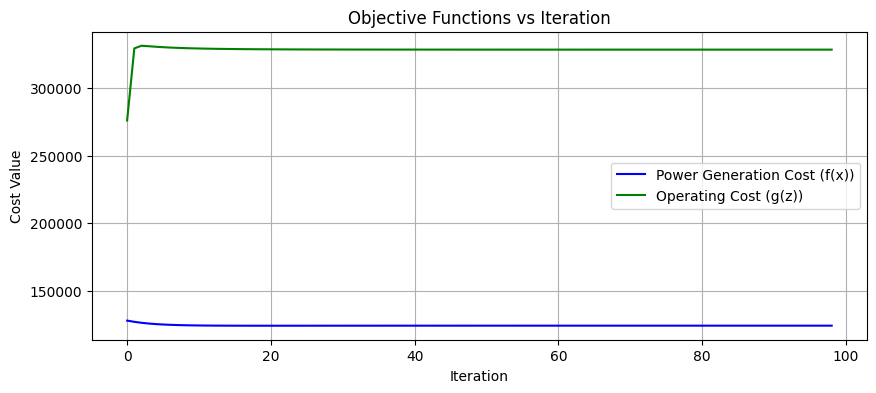

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# Load CSV (columns: iteration, residual, f_x, g_z)
df = pd.read_csv('convergence_log.csv')

# Plot Residual
plt.figure(figsize=(10,4))
plt.semilogy(df['iteration'], df['residual'], label='Primal Residual', color='black')
plt.xlabel('Iteration')
plt.ylabel('Residual (log scale)')
plt.title('ADMM Convergence Residual')
plt.grid(True)
plt.legend()
plt.show()

# Plot Objective Function Values
plt.figure(figsize=(10,4))
plt.plot(df['iteration'], df['f_x'], label='Power Generation Cost (f(x))', color='blue')
plt.plot(df['iteration'], df['g_z'], label='Operating Cost (g(z))', color='green')
plt.xlabel('Iteration')
plt.ylabel('Cost Value')
plt.title('Objective Functions vs Iteration')
plt.grid(True)
plt.legend()
plt.show()
